## Import Library

In [1]:
import pandas as pd
import sys
sys.path.append('..')
from src.plot import Ploter
from src.text_cleaner import TextCleaner

## Load Dataset

In [2]:
df = pd.read_csv('../data/raw/complaints.csv')
print('dataset shape', df.shape)
df.columns

C:\Users\PC\AppData\Local\Temp\ipykernel_27836\2166302647.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/complaints.csv')


dataset shape (9609797, 18)


Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

## Basic EDA

In [3]:
# Product distribution
product_counts = df['Product'].value_counts()
product_counts

Product
Credit reporting or other personal consumer reports                             4834855
Credit reporting, credit repair services, or other personal consumer reports    2163857
Debt collection                                                                  799197
Mortgage                                                                         422254
Checking or savings account                                                      291178
Credit card                                                                      226686
Credit card or prepaid card                                                      206369
Money transfer, virtual currency, or money service                               145066
Credit reporting                                                                 140429
Student loan                                                                     109717
Bank account or service                                                           86205
Vehicle loan or lease   

These are top complaint categories, showing that credit reporting and debt collection are major pain points.

By contrast, target products for the RAG system (Credit card, Personal loan, Savings account, Money transfer) are much smaller in volume.
This indicates that the dataset is heavily imbalanced, with most complaints related to credit reporting and debt collection.

In [4]:
ploter = Ploter()

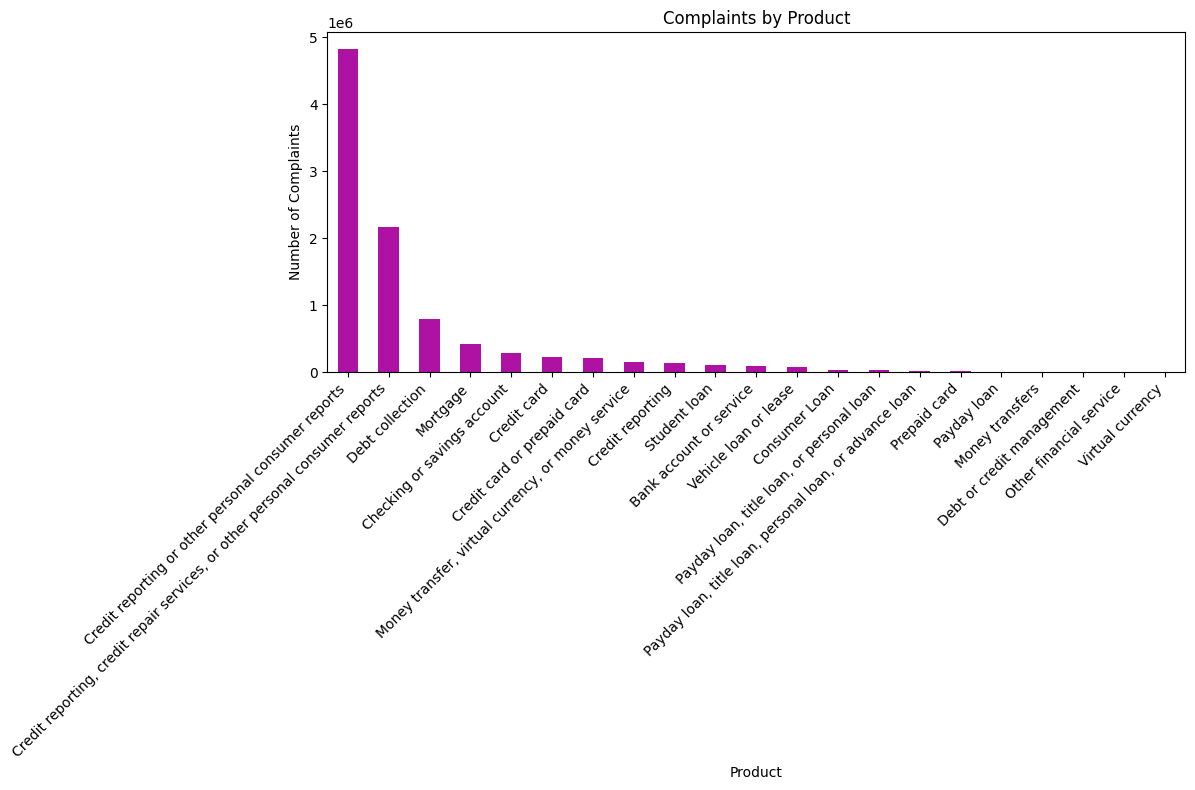

In [5]:
ploter.bar_ploter(product_counts)

In [6]:
# Analyze Narrative Lengths
# Create a column for word count of narratives
df['narrative_word_count'] = df['Consumer complaint narrative'].fillna('').apply(lambda x: len(x.split()))
# Summary statistics
print(df['narrative_word_count'].describe())

count    9.609797e+06
mean     5.446667e+01
std      1.497672e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.000000e+01
max      6.469000e+03
Name: narrative_word_count, dtype: float64


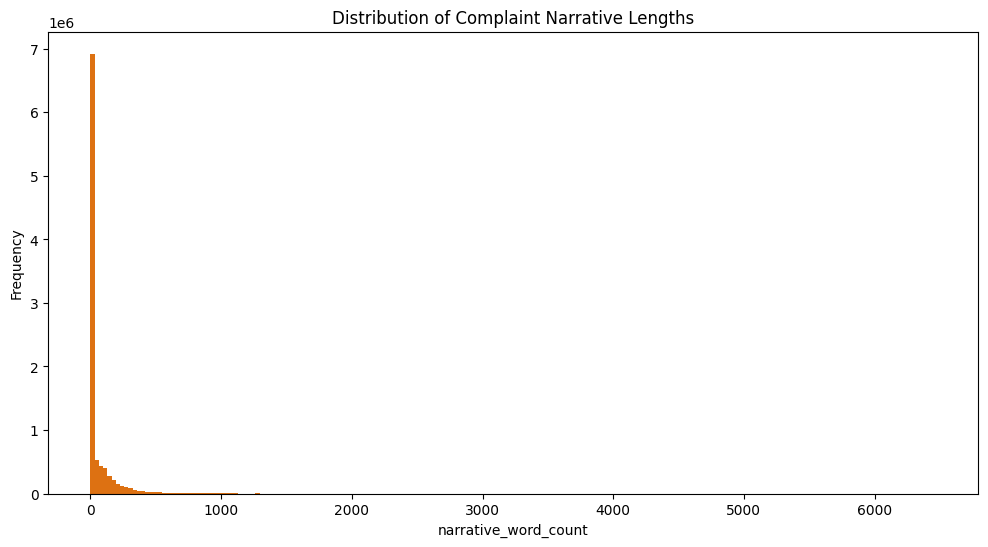

In [7]:
# Histogram of narrative lengths
ploter.hist_ploter(df['narrative_word_count'])

In [7]:
# Count complaints with and without narratives
with_narrative = df['Consumer complaint narrative'].notna().sum()
without_narrative = df.shape[0] - with_narrative
print(f'# Count complaints with narratives: {with_narrative}')
print(f'# Count complaints without narratives: {without_narrative}')

# Count complaints with narratives: 2980756
# Count complaints without narratives: 6629041


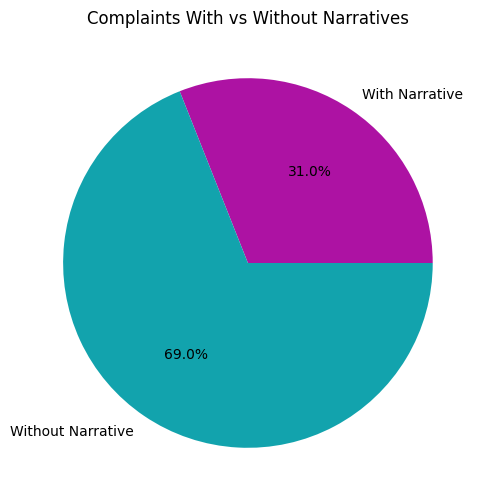

In [8]:
# Visualize as pie chart
ploter.pie_with(with_narrative,without_narrative)

Critical Observation: Complaint Narratives
Consumer complaint narrative: 6,629,041 missing
This means most complaints do not include free-text narratives
Since the RAG system relies on semantic understanding of narratives:
Complaints without narratives are unusable
These records must be removed

## Filter the dataset

In [9]:
# Make a copy to avoid chained assignment warnings
filtered_df = df.copy()
# Standardize product names to lowercase for matching
filtered_df['Product'] = filtered_df['Product'].str.lower()
# Define allowed products (lowercase)
allowed_products = [
    'credit card',
    'personal loan',
    'savings account',
    'money transfer'
]
# Keep only required products
filtered_df = filtered_df[filtered_df['Product'].apply(lambda x: any(p in x for p in allowed_products))]
# Remove records with missing or empty narratives
filtered_df = filtered_df[filtered_df['Consumer complaint narrative'].notna() & (filtered_df['Consumer complaint narrative'].str.strip()!="")]
print(f'Filtered dataset shape: {filtered_df.shape}')

Filtered dataset shape: (454472, 19)


## Text Cleaning

In [10]:
cleaner = TextCleaner()
filtered_df['cleaned_narrative'] = filtered_df['Consumer complaint narrative'].apply(cleaner.clean)

In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 454472 entries, 12237 to 9609743
Data columns (total 20 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 454472 non-null  object
 1   Product                       454472 non-null  object
 2   Sub-product                   435599 non-null  object
 3   Issue                         454472 non-null  object
 4   Sub-issue                     310876 non-null  object
 5   Consumer complaint narrative  454472 non-null  object
 6   Company public response       181608 non-null  object
 7   Company                       454472 non-null  object
 8   State                         449084 non-null  object
 9   ZIP code                      454472 non-null  object
 10  Tags                          80266 non-null   object
 11  Consumer consent provided?    454472 non-null  object
 12  Submitted via                 454472 non-null  object
 13 

## Save Cleaned Data

In [12]:
filtered_df.to_csv('../data/processed/filtered_complaints.csv')